# Parameter Estimation - Stochastic SIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
low_beta = 0.01 
high_beta = 1. 
low_gamma = 0.

def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for rate parameters: 
    beta_samples = np.random.uniform(low=low_beta, high=high_beta, size=batch_size)
    gamma_samples = np.random.uniform(low=low_gamma, high=beta_samples)
    p_samples = np.c_[beta_samples, gamma_samples]
    return p_samples.astype(np.float32)

N = 1000   # population size
u0 = [N-1,1,0]   # initial state  
iota = 0.5 
dt = 0.1   # time step
n_dt = 500   # number of simulation time steps
t_end = n_dt * dt
n_obs = 21   # number of observations
time_points = np.linspace(0, t_end, n_obs)

def simulate_sir_single(beta, gamma):
    """Simulates a single SIR process."""
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_obs)
    I = np.zeros(n_obs)
    R = np.zeros(n_obs)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        if j % 25 == 0:
            i = j//25
            S[i], I[i], R[i] = u
        
    return np.array([S, I, R]).T/N

def batch_simulator(prior_samples, n_obs):  
    """
    Simulate multiple SIR model data sets
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs, 3), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations
    
    for m in range(n_sim):
        sim_data[m] = simulate_sir_single(prior_samples[m, 0], prior_samples[m, 1])
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './SIR_stoch_5ACB_[64,64,64]_LSTM(128)_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./SIR_stoch_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


### Online training

In [ ]:
%%time
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=64, n_obs=n_obs)

## Computational faithfulness

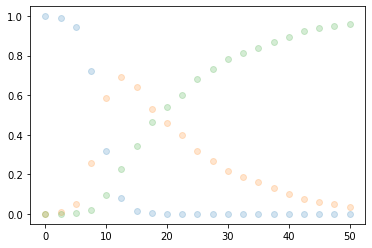

In [11]:
p = prior(1)
data = batch_simulator(p, n_obs)

for i in range(1):
    plt.plot(time_points, data[i,:,0], 'o', color='tab:blue', alpha=0.2)
    plt.plot(time_points, data[i,:,1], 'o', color='tab:orange', alpha=0.2)
    plt.plot(time_points, data[i,:,2], 'o', color='tab:green', alpha=0.2)

In [12]:
#param_prior = np.array([[-0.8, -1.4]]).astype(np.float32) # prior(1)   
n_post_samples = 7500 
param_samples = amortizer.sample(data, n_post_samples)   # BayesFlow samples from the learned posterior
print(p[0])

[0.81360096 0.07402787]


In [13]:
def simulate_sir_single_full(beta, gamma):
    """Simulates a single SIR process."""
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_dt+1)
    I = np.zeros(n_dt+1)
    R = np.zeros(n_dt+1)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        S[j], I[j], R[j] = u
        
    return np.array([S, I, R]).T/N

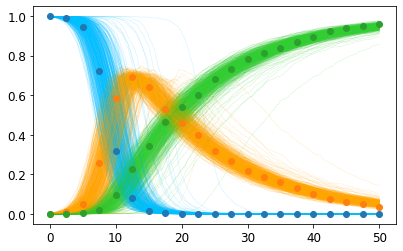

In [14]:
# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

time_line = np.linspace(0, t_end, n_dt+1)

for k in range(501): #1001
    sim_data = simulate_sir_single_full(param_samples[k, 0], param_samples[k, 1])
    if k == 0:
        plt.plot([0], sim_data[0,0], color='deepskyblue', label='Simulation $S$', linewidth=0.9)
        plt.plot([0], sim_data[0,1], color='orange', label='Simulation $I$', linewidth=0.9)
        plt.plot([0], sim_data[0,2], color='limegreen', label='Simulation $R$', linewidth=0.9)
    else: 
        plt.plot(time_line, sim_data[:,0], color='deepskyblue', linewidth=0.5, alpha=0.2)
        plt.plot(time_line, sim_data[:,1], color='orange', linewidth=0.5, alpha=0.2)
        plt.plot(time_line, sim_data[:,2], color='limegreen', linewidth=0.5, alpha=0.2)

plt.plot(time_points, data[0,:,0], 'o', color='tab:blue')
plt.plot(time_points, data[0,:,1], 'o', color='tab:orange')
plt.plot(time_points, data[0,:,2], 'o', color='tab:green')        

"""
rhs = lambda t,x: sir_dynamics(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,t_end), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[0]/N, color='black', label='True trajectories') 
plt.plot(sol.t, sol.y[1]/N, color='black')   
plt.plot(sol.t, sol.y[2]/N, color='black') 
plt.plot(time_points[result[1]], x_data[0,result[1],0], 'o', color='blue', label='Present data $S$')
plt.plot(time_points[result[1]], x_data[0,result[1],1], 'o', color='tab:orange', label='Present data $I$')
plt.plot(time_points[result[1]], x_data[0,result[1],2], 'o', color='green', label='Present data $R$')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,0,5,1,6,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, bbox_to_anchor=(1.42,0.84)) """
plt.show()
#fig.savefig("figures/{}_Re-simulation.png".format('SIR_4'), dpi=600, bbox_inches='tight')

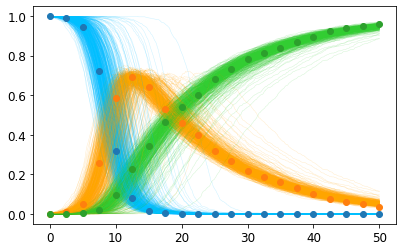

In [15]:
# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

time_line = np.linspace(0, t_end, n_dt+1)

for k in range(501): #1001
    sim_data = simulate_sir_single_full(p[0, 0], p[0, 1]) ### ground truth parameter
    plt.plot(time_line, sim_data[:,0], color='deepskyblue', linewidth=0.5, alpha=0.2)
    plt.plot(time_line, sim_data[:,1], color='orange', linewidth=0.5, alpha=0.2)
    plt.plot(time_line, sim_data[:,2], color='limegreen', linewidth=0.5, alpha=0.2)

plt.plot(time_points, data[0,:,0], 'o', color='tab:blue')
plt.plot(time_points, data[0,:,1], 'o', color='tab:orange')
plt.plot(time_points, data[0,:,2], 'o', color='tab:green')        

plt.show()
#fig.savefig("figures/{}_Re-simulation.png".format('SIR_4'), dpi=600, bbox_inches='tight')

In [34]:
def plot_predictive_check(ax, param_prior, x_data, param_samples, n_sim=1000):
    
    time_avail = time_points[x_data[:,3]==1]
    x_avail = x_data[x_data[:,3]==1, 0:3]
    
    grid = 181
    time_line = np.linspace(0, t_end, grid) 
    traj_sim = np.empty((n_sim, grid, 3))

    for k in range(n_sim):
        rhs = lambda t,x: sir_dynamics(t, x, param_samples[k])
        sol = solve_ivp(rhs, t_span = (0,t_end), t_eval = time_line, y0 = x0, atol = 1e-9, rtol = 1e-6)  
        traj_sim[k] = sol.y.T/N + np.random.normal(0, sigma, size=(grid, 3))
        
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    
    ax.plot(time_line, traj_mean[:,0], color='deepskyblue', label='Simulated mean $S$')
    ax.fill_between(time_line, traj_quantiles[0,:,0], traj_quantiles[1,:,0], color='deepskyblue', alpha=.25)
    ax.plot(time_line, traj_mean[:,1], color='orange', label='Simulated mean $I$')
    ax.fill_between(time_line, traj_quantiles[0,:,1], traj_quantiles[1,:,1], color='orange', alpha=.25)
    ax.plot(time_line, traj_mean[:,2], color='limegreen', label='Simulated mean $R$')
    ax.fill_between(time_line, traj_quantiles[0,:,2], traj_quantiles[1,:,2], color='limegreen', alpha=.25)
     
    rhs = lambda t,x: sir_dynamics(t, x, param_prior)
    sol = solve_ivp(rhs, t_span = (0,t_end), y0 = x0, atol = 1e-9, rtol = 1e-6)
    ax.plot(sol.t, sol.y[0]/N, color='black', linestyle='dashed', label='True trajectories') 
    ax.plot(sol.t, sol.y[1]/N, color='black', linestyle='dashed')   
    ax.plot(sol.t, sol.y[2]/N, color='black', linestyle='dashed') 
    
    ax.plot(time_avail, x_avail[:,0], 'o', color='tab:blue', markersize=4.25, label='Available data $S$')
    ax.plot(time_avail, x_avail[:,1], 'o', color='tab:orange', markersize=4.25, label='Available data $I$')
    ax.plot(time_avail, x_avail[:,2], 'o', color='tab:green', markersize=4.25, label='Available data $R$')
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

In [16]:
mean_sample = np.mean(param_samples, axis=0)
cov_sample = np.cov(param_samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

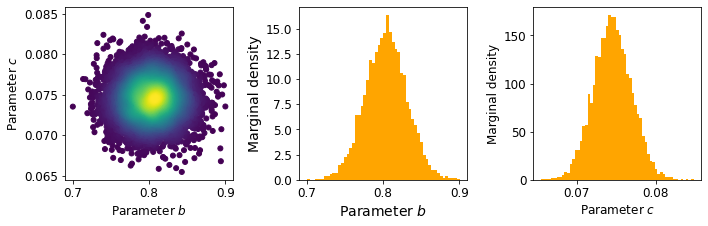

In [17]:
fig = plt.figure(figsize=(10, 3.3))
    
plt.subplot(1, 3, 1)
grid = 201
A = np.linspace(mean_x - 3.5 * std_x, mean_x + 3.5 * std_x, grid)
B = np.linspace(mean_y - 3.5 * std_y, mean_y + 3.5 * std_y, grid)
#levels = np.array([0.5, 1, 2.25, 4.5, 6.75])
#plt.clabel(true_posterior_2D, fontsize=9, inline=1)
# Kernel density estimator of BayesFlow samples
a = param_samples[:, 0]
b = param_samples[:, 1]
ab = np.vstack([a, b])
z = stats.gaussian_kde(ab)(ab)
ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
a, b, z = a[ida], b[ida], z[ida]
approximate_posterior = plt.scatter(a, b, c=z, s=25)
h2, _ = approximate_posterior.legend_elements()
#true = plt.scatter(param_prior[0, 0], param_prior[0, 1], c="tab:red", marker="x", s=150, linewidths=2.25, zorder=2)
#plt.legend([h2[0], h1[0], true], ['BayesFlow', 'True posterior', 'Ground truth'])
#plt.legend([h2[0], h1[0]], ['BayesFlow', 'True posterior'])
#plt.xticks([-2.0, -1.5, -1.0, -0.5])
#plt.yticks([-2.5, -2.0, -1.5, -1.0, -0.5])
plt.xlabel('Parameter $b$')
plt.ylabel('Parameter $c$')

grid = 151
A = np.linspace(mean_x - 5 * std_x, mean_x + 5 * std_x, grid)
B = np.linspace(mean_y - 5 * std_y, mean_y + 5 * std_y, grid)
plt.subplot(1, 3, 2)
plt.hist(param_samples[:, 0], bins='auto', density=1, color='orange', label='BayesFlow')
#plt.plot(A, marginal_x, color='b', label='True posterior')
#plt.vlines(param_prior[0,0], 0, 2.2, colors='tab:red', linestyles='solid', label='Ground truth', linewidths=2.)
plt.ylabel('Marginal density', fontsize=14)
plt.xlabel('Parameter $b$', fontsize=14)
#plt.legend()
plt.subplot(1, 3, 3)
plt.hist(param_samples[:, 1], bins='auto', density=1, color='orange', label='BayesFlow')
#plt.plot(B, marginal_y, color='b', label='True posterior')
#plt.vlines(param_prior[0,1], 0, 1.65, colors='tab:red', linestyles='solid', label='Ground truth', linewidths=2.)
plt.ylabel('Marginal density')
plt.xlabel('Parameter $c$')
#plt.legend()

plt.tight_layout()
plt.show()
#fig.savefig("figures/{}_posterior.png".format('SIR_4'), dpi=600, bbox_inches='tight')

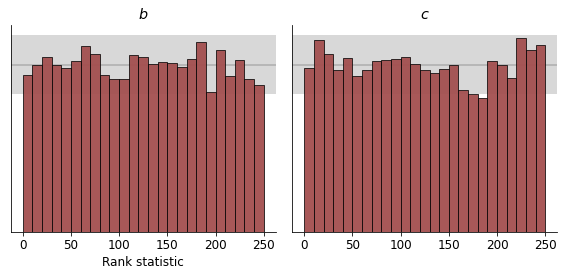

In [18]:
# simulation-based calibration
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$b$', '$c$'])

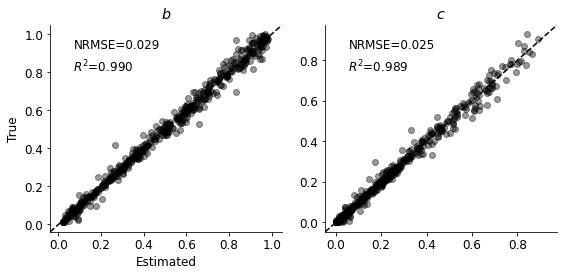

In [19]:
# Validation metrics
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$b$', '$c$'])